# DS405 Machine Learning Applications in Business and Economics Mini-Project
---

<font color="red">TBD: 
- What features to use? 
    - Construct new ones? 
    - Simply leave out all non-numeric features? 
    - Delivery-Delay might be interesting
    - Delivery Delay

- What is the goal of our model?
    - Avoid false negatives? This way returning customers will not receive a voucher. 

</font>


## Introduction

In the realm of e-commerce, a common observation is that a significant proportion of customers engage in a single transaction and then cease further purchases. This phenomenon can be attributed to a multitude of factors. To mitigate this, e-commerce platforms employ a variety of strategies aimed at fostering customer loyalty. One such strategy involves the distribution of discount vouchers subsequent to the initial purchase, with the goal of incentivizing repeat transactions. However, indiscriminate distribution of these vouchers may not be an optimal strategy. This is because a segment of customers might have engaged in repeat purchases even in the absence of such incentives. Consequently, the redemption of these vouchers by such customers translates into a reduction in the retailer’s profit. Empirical analyses conducted by the media retailer have demonstrated that for 10% of non-buyers, the voucher instigates a purchase with an average order value of €20. Thus, if a voucher is dispatched to a customer who would not have actually made another purchase, the revenue increases by an average of €1.5. On the other hand, sending a voucher to a customer who would have made a purchase anyway results in a revenue loss equivalent to the voucher value of €5. For customers who don’t receive a voucher, there is no impact on revenues. Therefore, it is crucial to devise a more targeted approach for the distribution of these vouchers.

## Task 

The task at hand involves constructing a predictive model that leverages various features associated with a customer’s initial order. The objective is to determine whether a €5.00 voucher should be issued to a specific customer. Detailed descriptions of these features can be found in the data dictionary.pdf file.
The model should be designed to predict if a customer will place a subsequent order within a 90-day period following their initial purchase. This information is represented by the target90 variable in the dataset. The model’s performance is evaluated based on the expected revenue across all customers in a given dataset. This is computed by considering the model’s predictions in conjunction with the associated costs and revenues. It’s crucial to note that the model’s effectiveness is directly tied to its ability to maximize this expected revenue. Hence, the model should be optimized with this specific goal in mind.


---

In [49]:
# Import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier # Binary dependent variable
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
import joblib # to save trained model 

### Step 1: Reading in and getting an overview of the data

In [50]:
# Separator is ;
train = pd.read_csv("train.csv", sep = ";")

# Dataset is wide, print all rows and only first 15 columns
train.describe().iloc[:,0:15]

C:\Users\benny\AppData\Local\Temp\ipykernel_16100\3775084309.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv", sep = ";")


,customernumber,salutation,title,domain,newsletter,model,paymenttype,deliverytype,invoicepostcode,voucher,case,numberitems,gift,entry,points
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.0
mean,33389.298569,0.541569,0.006969,7.517115,0.169483,1.646910,1.000987,0.201955,48.752282,0.162020,2.934378,2.019551,0.004564,0.414642,0.0
std,19148.090449,0.657044,0.083192,3.683945,0.375184,0.825981,1.092677,0.401465,24.361425,0.368475,1.319270,1.726046,0.067404,0.492668,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,16802.750000,0.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,30.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.0
50%,33552.500000,0.000000,0.000000,9.000000,0.000000,1.000000,1.000000,0.000000,47.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.0
75%,50034.250000,1.000000,0.000000,11.000000,0.000000,2.000000,2.000000,0.000000,66.000000,0.000000,4.000000,2.000000,0.000000,1.000000,0.0
max,66251.000000,2.000000,1.000000,12.000000,1.000000,3.000000,3.000000,1.000000,99.000000,1.000000,5.000000,50.000000,1.000000,1.000000,0.0


In [51]:
# Second half of the columns
# Dataset is wide, print all rows and only remaining columns
train.describe().iloc[:,15:]

,shippingcosts,weight,remi,cancel,used,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,target90
count,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000,32428.000000
mean,0.150611,637.920809,0.059979,0.061613,0.068860,0.902122,0.404342,0.276644,0.018903,0.047027,0.180986,0.027908,0.023128,0.000185,0.164981,0.092883,0.186598
std,0.357674,724.358131,0.388740,0.306833,0.474444,1.654767,1.410395,1.353981,0.253596,0.434265,0.561751,0.299862,0.401782,0.013601,0.836705,0.610509,0.389594
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,494.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,920.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,20076.000000,19.000000,17.000000,19.000000,99.000000,84.000000,90.000000,15.000000,36.000000,14.000000,27.000000,55.000000,1.000000,48.000000,50.000000,1.000000


Every column has a count of 32428 -> No missing values seem to be present. In the case of binary encoded variables, the mean directly reflects a percentage (if multiplied by 100). \
However, due to their datatype, some columns are not present in the .describe()-dataframe. Therefore, to fully detect all missing values, we loop over all columns in the as follows:

delivpostcode 31036
advertisingdatacode 25905


In [53]:
type(train["domain"][0])

numpy.int64

We only seem to have missing values in the *delivpostcode* and the *advertisingdatacode* column. \
One possible approach of fixing the issue in the *delivpostcode* column would be to simply impute the values of the *invoicepostcode* column. However, these values do not necessarily have to match. \
For the *advertisingdatacode* column, we do not have a logical approach of dealing with these rather unique data type and its missing values.  

- Preprocessing for one hot encoding

In [54]:
# Domain
for i in range(len(train["domain"])):
    value = train["domain"].iloc[i]
    if value == 0:
        train.loc[i, "domain"] = "aol.com"
    elif value == 1:
        train.loc[i, "domain"] = "arcor.de"
    elif value == 2:
        train.loc[i, "domain"] = "freenet.de"
    elif value == 3:
        train.loc[i, "domain"] = "gmail.com"
    elif value == 4:
        train.loc[i, "domain"] = "gmx.de"
    elif value == 5:
        train.loc[i, "domain"] = "hotmail.de"
    elif value == 6:
        train.loc[i, "domain"] = "online.de"
    elif value == 7:
        train.loc[i, "domain"] = "onlinehome.de"
    elif value == 8:
        train.loc[i, "domain"] = "t-online.de"
    elif value == 9:
        train.loc[i, "domain"] = "web.de"
    elif value == 10:
        train.loc[i, "domain"] = "yahoo.com"
    elif value == 11:
        train.loc[i, "domain"] = "yahoo.de"
    elif value == 12:
        train.loc[i, "domain"] = "others"

# Salutation
for i in range(len(train["salutation"])):
    value = train["salutation"].iloc[i]
    if value == 0:
        train.loc[i, "salutation"] = "Ms."
    elif value == 1:
        train.loc[i, "salutation"] = "Mr."
    elif value == 2:
        train.loc[i, "salutation"] = "Company"
    
# Payment-type
for i in range(len(train["paymenttype"])):
    value = train["paymenttype"].iloc[i]
    if value == 0:
        train.loc[i, "paymenttype"] = "Invoice"
    elif value == 1:
        train.loc[i, "paymenttype"] = "Cash"
    elif value == 2:
        train.loc[i, "paymenttype"] = "Transfer"
    elif value == 3:
        train.loc[i, "paymenttype"] = "Credit"


C:\Users\benny\AppData\Local\Temp\ipykernel_16100\2154899247.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'web.de' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[i, "domain"] = "web.de"


C:\Users\benny\AppData\Local\Temp\ipykernel_16100\2154899247.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Ms.' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[i, "salutation"] = "Ms."
C:\Users\benny\AppData\Local\Temp\ipykernel_16100\2154899247.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Transfer' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[i, "paymenttype"] = "Transfer"


In [55]:
# Convert to dummy variables
train = pd.get_dummies(train, columns=["domain", "salutation", "model", "paymenttype"])

---

#### Computing delivery delay

We expect a potential delay in the delivery to have a systematic influence on a customer's re-purchase probability. The longer this delay gets, the less likely an expected re-purchase will become. 

In [56]:
# Convert actual delivery date to datetime
for i in range(len(train)):  
    if train.loc[i, "deliverydatereal"].startswith("0000"):  
        train.loc[i, "deliverydatereal"] = np.nan
    else:
        train.loc[i, "deliverydatereal"] = pd.to_datetime(train.loc[i, "deliverydatereal"])

# Convert promised delivery date to datetime
for i in range(len(train)):
    if train.loc[i, "deliverydatepromised"].startswith("0000"): # disregard missing values
        train.loc[i, "deliverydatepromised"] = np.nan
    else:
        try: # Exception had to be added because some dates were out of bounds (Year 4746)
            train.loc[i, "deliverydatepromised"] = pd.to_datetime(train.loc[i, "deliverydatepromised"])
        except pd.errors.OutOfBoundsDatetime:
            train.loc[i, "deliverydatepromised"] = np.nan

# Compute actual delay in timedelta format
train["delay"] = [0] * len(train)

for i in range(len(train)):
    if pd.notna(train["deliverydatereal"][i]) and pd.notna(train["deliverydatepromised"][i]):
        train.loc[i, "delay"] = train["deliverydatereal"][i] - train["deliverydatepromised"][i]
    else:
        train.loc[i, "delay"] = np.nan

# Get days of delay
for i in range(len(train)):
    if pd.notna(train["delay"][i]):
        train.loc[i, "delay"] = train["delay"][i].days
    else:
        train.loc[i, "delay"] = np.nan

missing_values = train["delay"].isna().sum()
print(f"Number of missing values in Delay column: {missing_values}")  


C:\Users\benny\AppData\Local\Temp\ipykernel_16100\2369885331.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1 days +00:00:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[i, "delay"] = train["deliverydatereal"][i] - train["deliverydatepromised"][i]


Number of missing values in Delay column: 5478


Unfortunately, only few classifiers can work with NaNs. Since we have over 5000 missing values, different ways of imputing them could have a considerable impact on our model predictions. \
Therefore we disregard the Delivery Delay variable and stick to the original data set. 

---

#### Further setup

- Function to evaluate model precision

In [57]:
# Only includes training data for now (handle division by 0)
def evaluate_model(y_train, y_train_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_train_pred)): 
        if y_train[i]==y_train_pred[i]==1:
           TP += 1
        if y_train_pred[i]==1 and y_train[i]!=y_train_pred[i]:
           FP += 1
        if y_train[i]==y_train_pred[i]==0:
           TN += 1
        if y_train_pred[i]==0 and y_train[i]!=y_train_pred[i]:
           FN += 1

    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    # Print results
    print("Accuracy:", accuracy)
    print("Precision (Share of positives correctly specified):", precision) # of all actual 1s, how many did we predict as 1
    print("Sensitivity (Share of actual true values found):", sensitivity) # of all our predictions with 1, how many were actually 1
    print("Specificity (Share of actual false values found):", specificity) # of all our predictions with 0, how many were actually 0
    print(f"TP: {TP}", f"FP: {FP}", f"TN: {TN}", f"FN: {FN}")


- Constructing the training data set

In [59]:
train.columns

Index(['customernumber', 'date', 'title', 'datecreated', 'newsletter',
       'deliverytype', 'invoicepostcode', 'delivpostcode', 'voucher',
       'advertisingdatacode', 'case', 'numberitems', 'gift', 'entry', 'points',
       'shippingcosts', 'deliverydatepromised', 'deliverydatereal', 'weight',
       'remi', 'cancel', 'used', 'w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6',
       'w7', 'w8', 'w9', 'w10', 'target90', 'domain_aol.com',
       'domain_arcor.de', 'domain_freenet.de', 'domain_gmail.com',
       'domain_gmx.de', 'domain_hotmail.de', 'domain_online.de',
       'domain_onlinehome.de', 'domain_others', 'domain_t-online.de',
       'domain_web.de', 'domain_yahoo.com', 'domain_yahoo.de',
       'salutation_Company', 'salutation_Mr.', 'salutation_Ms.', 'model_1',
       'model_2', 'model_3', 'paymenttype_Cash', 'paymenttype_Credit',
       'paymenttype_Invoice', 'paymenttype_Transfer', 'delay'],
      dtype='object')

In [70]:
# Function to check for NAs in every column
def count_na(df):
    for col in df.columns:          # Loop over all columns
        n_na = df[col].isna().sum() # Count occurrences of missing values
        if n_na > 0:                # Only give column and count if there actually are NAs
            print(col, n_na)        # Print column name and number of NAs

# Apply function
count_na(train)

delivpostcode 31036
advertisingdatacode 25905
deliverydatepromised 9
deliverydatereal 5472
delay 5478


In [68]:
# Construct dependent variable -> label 
y_train = train["target90"]

# Construct explanatory variables -> features (invoicepostcode may be kept as a feature)
x_train = train.drop(["customernumber", "date", "datecreated", "invoicepostcode", "delivpostcode", "advertisingdatacode",
                       "deliverydatepromised", "deliverydatereal", "target90", "delay"], axis = 1)

In [71]:
count_na(x_train)

In [65]:
disregarded_columns = []
for col in train.columns:
    if col not in x_train.columns:
        disregarded_columns.append(col)
print(disregarded_columns)

['customernumber', 'date', 'datecreated', 'invoicepostcode', 'delivpostcode', 'advertisingdatacode', 'deliverydatepromised', 'deliverydatereal', 'target90']


- **Customernumber**: We don't expect the customernumer assigned to an individual to have a systematic influence on a customer's re-purchase probability.
- **Date**: We don't expect the date to have a systematic influence on a customer's re-purchase probability.
- **Datecreated**: We don't expect the date of account creation to have a systematic influence on a customer's re-purchase probability.
- **Invoicepostcode**: We dont't expect the postcode of the invoice to have a systematic influence on a customer's re-purchase probability. 
- **Delivpostcode**: Too many missing values.
- **Advertisingdatacode**: Too many missing values.
- **Deliverydatepromised**: We don't expect the promised delivery date to have a systematic influence on a customer's re-purchase probability.
- **Deliverydatereal**: We don't expect the actual delivery date to have a systematic influence on a customer's re-purchase probability.
- **Delay**: We did expect the delivery delay to have a systematic influence on a customer's re-purchase probability. However, there are too many missing values present. 
- **Target90**: This is the label we want to predict, therefore we do not include it in the training process.
                

---

### First try of estimation with RandomForestClassifier

In [72]:
# Just to check if we can actually estimate the data set
forest = RandomForestClassifier(n_estimators = 20, max_depth = 100, min_samples_split = 2, min_samples_leaf = 1, criterion = "entropy", bootstrap = True, random_state = 0)
forest.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, n_estimators=20,
                       random_state=0)

In [73]:
# Get Model predictions
y_train_pred = forest.predict(x_train)

In [74]:
# Evaluate accuracy of cross-validated model 
evaluate_model(y_train, y_train_pred)

Accuracy: 0.9631182928333539
Precision (Share of positives correctly specified): 0.9787024255570893
Sensitivity (Share of actual true values found): 0.8201950090894067
Specificity (Share of actual false values found): 0.9959055237517535
TP: 4963 FP: 108 TN: 26269 FN: 1088


Of course we heavily overfit to our training data. But it is nice to see, that we can actually predict our data precisely. 

- First hyperparameter-tuning attempt with RandomizedSearchCV

In [75]:
# Setup ranges for different parameters for hyperparameter tuning
max_depth = range(10,20) 
min_samples_split = range(10,20)
min_samples_leaf = range(5,20)
n_estimators = range(30,50)
#cv = range(4,10)

# Collect in dictionary
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}

# Set up forest classifier
forest = RandomForestClassifier()
# Set up RandomizedSearchCV
forest_cv = RandomizedSearchCV(forest, param_dist, n_jobs = -1, verbose = 1, n_iter = 1000, scoring = 'accuracy', cv = 5)#, random_state = 0) # not same results though

# Fit it to the data
forest_cv.fit(x_train,y_train) # does it automatically use best parameters? 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=1000,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(10, 20),
                                        'min_samples_leaf': range(5, 20),
                                        'min_samples_split': range(10, 20),
                                        'n_estimators': range(30, 50)},
                   scoring='accuracy', verbose=1)

- Second hyperparameter-tuning attempt around the best parameters from the first attempt

In [79]:
# Grab optimal parameters from previous CV
best_depth = forest_cv.best_params_["max_depth"]
best_split = forest_cv.best_params_["min_samples_split"]
best_leaf = forest_cv.best_params_["min_samples_leaf"]
best_est = forest_cv.best_params_["n_estimators"]


# Set range around previous optimal parameters to search for even better parameters
max_depth = range(best_depth - 2, best_depth + 2)
min_samples_split = range(best_split - 2, best_split + 2)
min_samples_leaf = range(best_leaf - 2, best_leaf + 2)
n_estimators = range(best_est - 2, best_est + 2)


# Collect in dicionary
param_dist = {'max_depth': max_depth,'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'n_estimators': n_estimators}

# Set up forest
forest = RandomForestClassifier()
# Set up RandomizedSearchCV
forest_cv2 = RandomizedSearchCV(forest, param_dist, n_jobs = -1, cv = 5,verbose = 1, n_iter = 500, scoring = 'accuracy')
# Fit it to the data
forest_cv2.fit(x_train, y_train) # does it automatically use best parameters? 

C:\Users\benny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 256 is smaller than n_iter=500. Running 256 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 256 candidates, totalling 1280 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(15, 19),
                                        'min_samples_leaf': range(3, 7),
                                        'min_samples_split': range(8, 12),
                                        'n_estimators': range(31, 35)},
                   scoring='accuracy', verbose=1)

In [76]:
# Predict and evaluate first cv model
y_train_pred_cv = forest_cv.predict(x_train)
evaluate_model(y_train, y_train_pred_cv) 

Accuracy: 0.8154989515233748
Precision (Share of positives correctly specified): 0.9473684210526315
Sensitivity (Share of actual true values found): 0.011898859692612791
Specificity (Share of actual false values found): 0.9998483527315464
TP: 72 FP: 4 TN: 26373 FN: 5979


In [80]:
# Predict and evaluate second cv model
y_train_pred_cv2 = forest_cv2.predict(x_train)
evaluate_model(y_train, y_train_pred_cv2)

Accuracy: 0.8188910817811768
Precision (Share of positives correctly specified): 0.9540816326530612
Sensitivity (Share of actual true values found): 0.030903982812758222
Specificity (Share of actual false values found): 0.9996587936459794
TP: 187 FP: 9 TN: 26368 FN: 5864


Text(0.5, 1.0, 'Random Forest Regression Feature Importances')

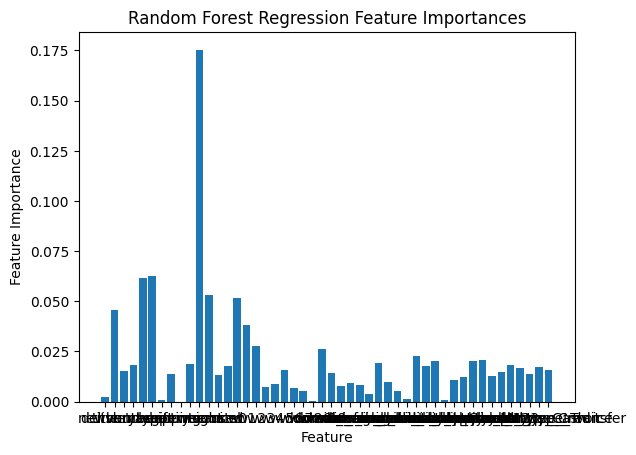

In [81]:
# Plot feature importance
fig = plt.figure()
ax = fig.gca() #get current axis
ax.bar(range(x_train.shape[1]), forest_cv2.best_estimator_.feature_importances_)
ax.set_xticks(np.arange(x_train.shape[1]))
ax.set_xticklabels([f'{col}' for col in x_train.columns])
ax.set_xlabel('Feature')
ax.set_ylabel('Feature Importance')
ax.set_title('Random Forest Regression Feature Importances')

# Ugly ass graph but its working 

In [82]:
# Get feature importances with names 
importance = pd.DataFrame(forest_cv2.best_estimator_.feature_importances_)
feature_names = pd.DataFrame(x_train.columns)
feature_importances = pd.concat([importance, feature_names], axis = 1)

# Name columns accordingly
feature_importances.columns = ["Importance", "Feature"]
feature_importances.sort_values(by = "Importance", ascending = False)

,Importance,Feature
10,0.175421,weight
5,0.062483,numberitems
4,0.061742,case
11,0.052939,remi
14,0.051497,w0
1,0.045734,newsletter
15,0.037986,w1
16,0.027493,w2
23,0.026186,w9
33,0.022756,domain_others


In [29]:
# Now what to we do with this? Can we just leave out the worst 10 features for example? 
# Random forest not really useful in predicting true positives

---

### Ada Boost

In [84]:
ada = AdaBoostClassifier(n_estimators = 500, learning_rate = 0.8)
ada = ada.fit(x_train, y_train)

In [85]:
y_train_pred_ada = ada.predict(x_train)
evaluate_model(y_train, y_train_pred_ada)

Accuracy: 0.813987911681263
Precision (Share of positives correctly specified): 0.5714285714285714
Sensitivity (Share of actual true values found): 0.012559907453313502
Specificity (Share of actual false values found): 0.9978390264245365
TP: 76 FP: 57 TN: 26320 FN: 5975


In [32]:
# Setup ranges for different parameters for hyperparameter tuning
max_depth = range(1,5) 
n_estimators = range(10,50)
learning_rate = np.arange(0.5, 5, 0.25) # In Adaboost learning rate can go to infinity (weights of previous misclassifications)
#cv = range(4,10)

# What about depth of base estimator? 

# Collect in dictionary
param_dist = {'n_estimators': n_estimators, "learning_rate": learning_rate}

# Set up AdaBoost classifier
ada = AdaBoostClassifier()
# Set up RandomizedSearchCV
ada_cv = RandomizedSearchCV(ada, param_dist, n_jobs = -1, verbose = 1, n_iter = 1000, scoring = 'accuracy', cv = 5)
# Fit it to the data
ada_cv.fit(x_train,y_train) 

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


C:\Users\benny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 720 is smaller than n_iter=1000. Running 720 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=AdaBoostClassifier(), n_iter=1000, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  ,
       3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75]),
                                        'n_estimators': range(10, 50)},
                   scoring='accuracy', verbose=1)

In [33]:
# Get predictions from AdaCV model
y_train_pred_ada_cv = ada_cv.predict(x_train)
# Evaluate accuracy of cross-validated model
evaluate_model(y_train, y_train_pred_ada_cv)

Accuracy: 0.8134636733686937
Precision (Share of positives correctly specified): 0.625
Sensitivity (Share of actual true values found): 0.0008263097008758883
Specificity (Share of actual false values found): 0.9998862645486598
TP: 5 FP: 3 TN: 26374 FN: 6046


---

### XGBoost

In [86]:
gbrt = GradientBoostingClassifier(max_depth = 10, n_estimators = 50, learning_rate = 0.5)
gbrt.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=10, n_estimators=50)

In [35]:
# Test-wise save of the model
joblib.dump(gbrt, "gbrt.joblib")

['gbrt.joblib']

In [87]:
# Get predictions for initial values
y_train_pred_gbrt = gbrt.predict(x_train)
# Evaluate model predictions
evaluate_model(y_train, y_train_pred_gbrt)

Accuracy: 0.9439681756506723
Precision (Share of positives correctly specified): 0.9877880184331798
Sensitivity (Share of actual true values found): 0.7084779375309866
Specificity (Share of actual false values found): 0.9979906736929901
TP: 4287 FP: 53 TN: 26324 FN: 1764


In [88]:
# Setup parameter distributions for hyperparameter tuning
max_depth = range(8, 15)
n_estimators = range(30,40)
learning_rate = np.arange(0.4, 0.9, 0.1) # so far it always outputs first value in list as best parameter
param_dist = {"max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate}

# Set up GradientBoostingClassifier
gbrt = GradientBoostingClassifier()
# Set up RandomizedSearchCV
gbrt_cv = RandomizedSearchCV(gbrt, param_dist, n_jobs = -1, cv = 5, verbose = 1, n_iter = 100, scoring = 'accuracy')
# Fit it to the data
gbrt_cv.fit(x_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'max_depth': range(8, 15),
                                        'n_estimators': range(30, 40)},
                   scoring='accuracy', verbose=1)

In [89]:
gbrt_cv.best_params_

{'n_estimators': 33, 'max_depth': 8, 'learning_rate': 0.4}

In [90]:
y_train_pred_gbrt_cv = gbrt_cv.predict(x_train)

evaluate_model(y_train, y_train_pred_gbrt_cv)

Accuracy: 0.8639447391143457
Precision (Share of positives correctly specified): 0.9739733950260266
Sensitivity (Share of actual true values found): 0.2783011072549992
Specificity (Share of actual false values found): 0.9982939682298972
TP: 1684 FP: 45 TN: 26332 FN: 4367
